In [19]:
from cmdstanpy import CmdStanModel
import pandas as pd
import arviz as az 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from dags import plot_poisson_dag, plot_negative_binomial_dag


# SEED = 19 + 14 ## sum of length of our full names or just use 42
SEED = 19052025

In [20]:
MODEL_PATH_1 = "code_1.stan"
MODEL_PATH_1_PPC = "code_1_pcc.stan"

MODEL_PATH_2 = "code_2.stan"
MODEL_PATH_2_PPC = "code_2_ppc.stan"

### 2. Data Preprocessing

In [21]:
df = pd.read_csv("globalterrorismdb_0718dist.csv", encoding='latin-1')
df.head()

/tmp/ipykernel_14/2798381327.py:1: DtypeWarning: Columns (4,6,31,33,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("globalterrorismdb_0718dist.csv", encoding='latin-1')


,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


In [22]:
selected_columns = ['nkill', 'attacktype1_txt', 'weaptype1_txt', 'targtype1_txt', 'country_txt', 'nperps']
df = df[selected_columns].dropna()  # Filter out rows where 'nkill' is zero or negative
print(len(df), "rows in the dataset before filtering")
df = df[(df['nperps'] > 0) & (df['nperps'] < 500)]
 # Filter out rows where 'nperps' is zero or negative
print(len(df), "rows in the dataset after filtering nperps > 0")
df = df.sample(n=500, random_state=123)
df.to_csv('data.csv')
print(len(df), "rows in the dataset after filtering")
df.head()

106122 rows in the dataset before filtering
27190 rows in the dataset after filtering nperps > 0
500 rows in the dataset after filtering


,nkill,attacktype1_txt,weaptype1_txt,targtype1_txt,country_txt,nperps
178855,0.0,Hostage Taking (Kidnapping),Unknown,Government (General),Nepal,8.0
45750,1.0,Assassination,Melee,Private Citizens & Property,Israel,1.0
135671,1.0,Bombing/Explosion,Explosives,Educational Institution,Nigeria,1.0
103306,1.0,Armed Assault,Firearms,Private Citizens & Property,Nigeria,2.0
109153,1.0,Bombing/Explosion,Explosives,Private Citizens & Property,Iraq,1.0


In [23]:
# categorical_cols = ['attacktype1_txt', 'weaptype1_txt', 'targtype1_txt', 'country_txt']
# numerical_col = ['nperps']

# df_dummies = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# # Normalizacja tylko dla 'nperps'
# df_dummies['nperps'] = (df_dummies['nperps'] - df_dummies['nperps'].mean()) / df_dummies['nperps'].std()

# # Przygotowanie X i y
# X = df_dummies.drop(columns=['nkill']).astype(float).to_numpy()
# y = df_dummies['nkill'].astype(int).to_numpy()

In [24]:
X

array([[ 0.35185383,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.16289987,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.33242916,  1.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.16289987,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.16289987,  0.        ,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.16289987,  0.        ,  1.        , ...,  0.        ,
         0.        ,  0.        ]], shape=(106122, 229))

In [27]:
categorical_cols = ['attacktype1_txt', 'weaptype1_txt', 'targtype1_txt', 'country_txt']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Normalizacja tylko nperps
df_encoded['nperps'] = (df_encoded['nperps'] - df_encoded['nperps'].mean()) / df_encoded['nperps'].std()

# Przygotowanie X i y
X = df_encoded.drop(columns=['nkill'])
X_matrix = X.to_numpy().astype(float)
y = df_encoded['nkill'].astype(int).to_numpy()

# Stanowe dane wejściowe
N_days = len(df)
print("Number of days/observations:", N_days)

data_sim_ppc = {
    'N': N_days,
    'K': X_matrix.shape[1],
    'X': X_matrix,
    'nkill': y
}

data_sim_prod = {
    'N': N_days,
    'K': X_matrix.shape[1],
    'X': X_matrix,
    'nkill': y
}

Number of days/observations: 500


### 3. Model

In [28]:
def scatter_hist_display(val_mat, y_values):
    # plt.figure(dpi=300)
    fig, axs = plt.subplots(2, len(val_mat.columns), dpi=300)
    fig.set_size_inches(5*len(val_mat.columns), 10)

    for i, col in enumerate(val_mat.columns):
        axs[0, i].scatter(val_mat[col], y_values)
        axs[0, i].set_title(col)
        axs[0, i].set_ylabel(y_values.name)
        axs[0, i].grid()

        axs[1, i].hist(val_mat[col])
        axs[1, i].set_ylabel("Density")
        axs[1, i].set_xlabel(col)
        axs[1, i].grid()

def hist_compare(y_real, y_gen):
    plt.figure(dpi=150)
    y_real.hist(alpha=0.5, label="Real")
    y_gen.hist(alpha=0.5, label="Generated", bins=23)
    plt.legend()
    plt.title("Generated samples")
    plt.xlabel(y_real.name)
    plt.grid()
    plt.show()

def scatter_compare_display(val_mat, y_values_orig, y_values_gen):
    # plt.figure(dpi=300)
    fig, axs = plt.subplots(1, len(val_mat.columns), dpi=300)
    fig.set_size_inches(5*len(val_mat.columns), 5)

    for i, col in enumerate(val_mat.columns):
        axs[i].scatter(val_mat[col], y_values_orig, alpha=0.8, label="Original")
        axs[i].scatter(val_mat[col], y_values_gen, alpha=0.8, label="Generated")
        axs[i].set_title(col)
        axs[i].set_ylabel(y_values_orig.name)
        axs[i].set_xlabel(col)
        axs[i].grid()
        axs[i].legend()

In [29]:
scatter_hist_display(X, df["nkill"])


/usr/local/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7124: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  m, bins = np.histogram(x[i], bins, weights=w[i], **hist_kwargs)


TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

Error in callback <function flush_figures at 0x7f7e8f5c74c0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [30]:
data_sim_prod

{'N': 500,
 'K': 111,
 'X': array([[-0.12476657,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.35679792,  1.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.35679792,  0.        ,  1.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [-0.29050325,  1.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.32365059,  1.        ,  0.        , ...,  1.        ,
          0.        ,  0.        ],
        [-0.25735592,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]], shape=(500, 111)),
 'nkill': array([  0,   1,   1,   1,   1,   1,   0,   0,   0,   0,   0,   1,  10,
          9,   1,  19,   0,   5,   0,   0,   1,   5,   0,   0,   6,   0,
          1,   1,   0,   1,   5,   0,   2,   1,   2,   0,   2,   0,   1,
          0,   1,  35,   1,   4,   0,   3,   0,   0,   6,   1,   0,   1,
          2,   0,   1,   0,

### 4. Priors

#### Model 1

In [31]:
model1_ppc = CmdStanModel(stan_file=MODEL_PATH_1_PPC)

sim1 = model1_ppc.sample(data=data_sim_ppc,
                        seed=123)

df_1_ppc = sim1.draws_pd()

13:19:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:19:01 - cmdstanpy - INFO - CmdStan done processing.


In [32]:
df_1_ppc

,chain__,iter__,draw__,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,...,nkill_sim[491],nkill_sim[492],nkill_sim[493],nkill_sim[494],nkill_sim[495],nkill_sim[496],nkill_sim[497],nkill_sim[498],nkill_sim[499],nkill_sim[500]
0,1.0,1.0,1.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,5.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0
1,1.0,2.0,2.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,22.0,14.0,11.0,25.0,20.0,15.0,19.0,25.0,14.0,14.0
2,1.0,3.0,3.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,4.0,16.0,2.0,10.0,8.0,3.0,16.0,9.0,6.0,13.0
3,1.0,4.0,4.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,13.0,7.0,13.0,19.0,9.0,12.0,8.0,5.0,20.0,13.0
4,1.0,5.0,5.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,23.0,11.0,19.0,22.0,13.0,17.0,12.0,11.0,13.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,4.0,996.0,3996.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,33.0,31.0,37.0,32.0,23.0,40.0,18.0,24.0,18.0,41.0
3996,4.0,997.0,3997.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,8.0,2.0,12.0,14.0,13.0,19.0,28.0,18.0,15.0,18.0
3997,4.0,998.0,3998.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,4.0,5.0,6.0,10.0,20.0,4.0,11.0,17.0,5.0,6.0
3998,4.0,999.0,3999.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,19.0,20.0,11.0,10.0,14.0,9.0,7.0,13.0,13.0,12.0


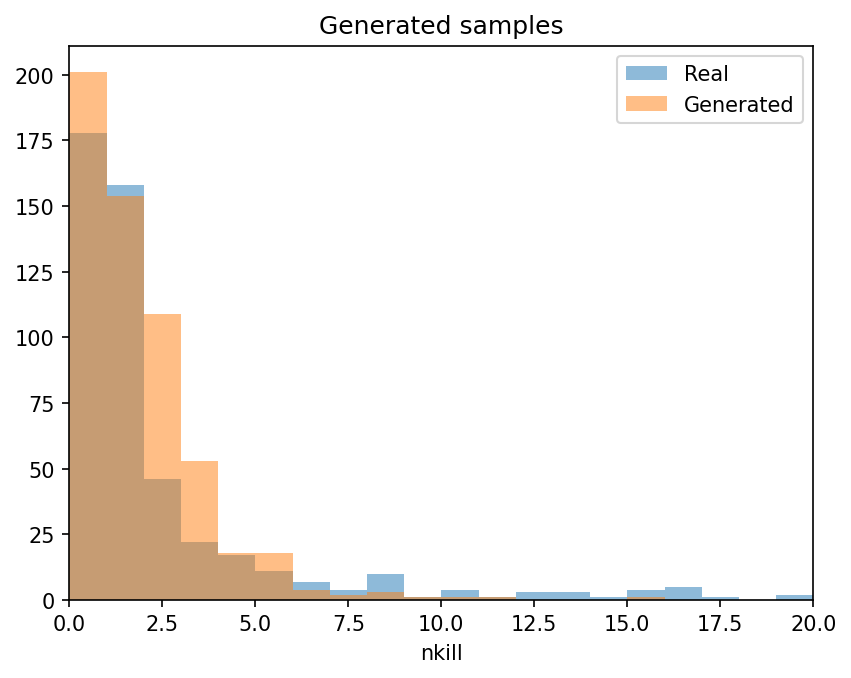

In [33]:
def hist_compare(y_real, y_gen):
    plt.figure(dpi=150)
    max_val = int(max(y_real.max(), y_gen.max())) + 1
    bins = range(0, max_val + 1)
    y_real.hist(alpha=0.5, label="Real", bins=bins)
    y_gen.hist(alpha=0.5, label="Generated", bins=bins)
    plt.legend()
    plt.title("Generated samples")
    plt.xlabel(y_real.name)
    plt.xlim(0,20)
    plt.grid()
    plt.show()


hist_compare(df['nkill'], df_1_ppc.iloc[0][8:])

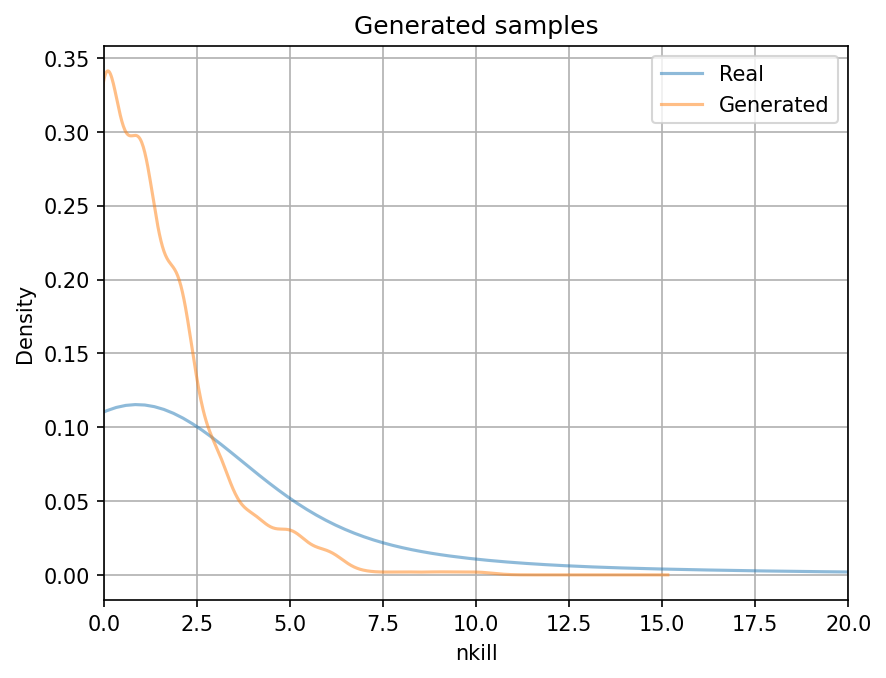

In [ ]:
def kde_compare(y_real, y_gen):
    plt.figure(dpi=150)
    y_real.plot.kde(alpha=0.5, label="Real")
    y_gen.plot.kde(alpha=0.5, label="Generated")
    plt.legend()
    plt.title("Generated samples")
    plt.xlabel(y_real.name)
    plt.xlim(0, 20)
    plt.grid()
    plt.show()

kde_compare(df['nkill'], df_1_ppc.iloc[0][8:])

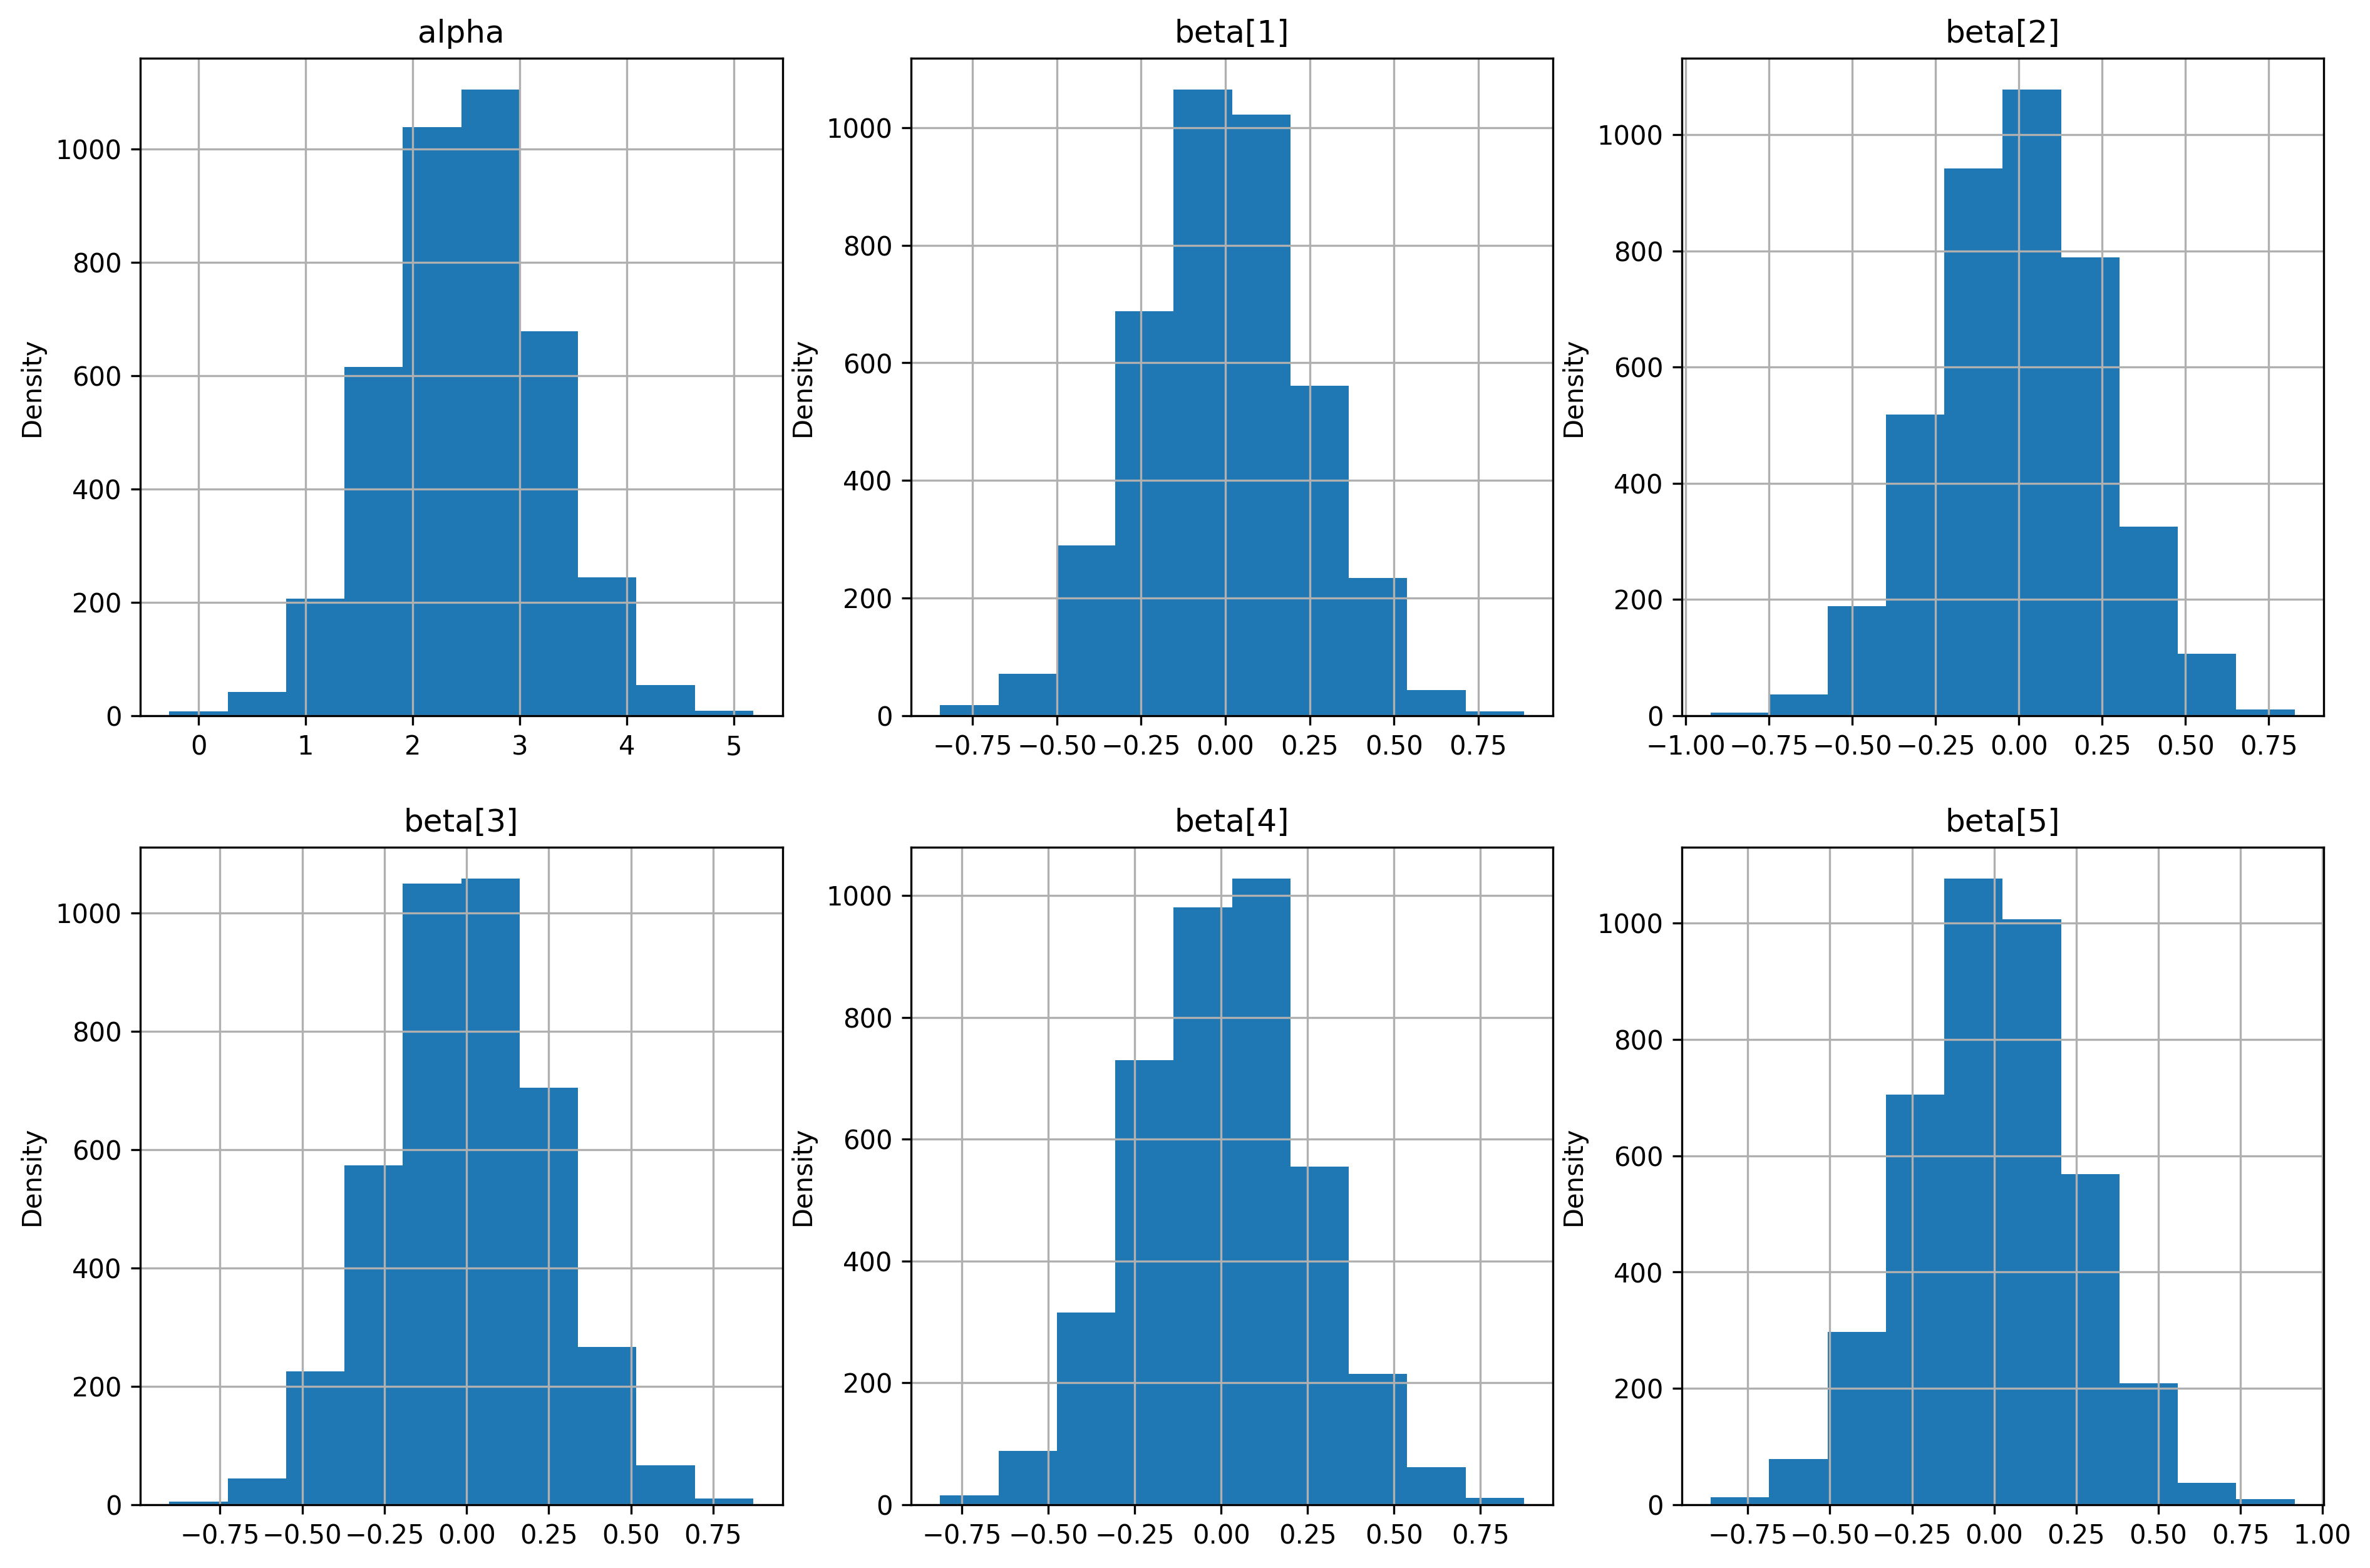

In [34]:
fig, axs = plt.subplots(2, 3, dpi=300)
fig.set_size_inches(15, 10)

for i, col in enumerate(["alpha", 'beta[1]', 'beta[2]', 'beta[3]', 'beta[4]', 'beta[5]']):
    axs[i//3, i%3].hist(df_1_ppc[col])
    axs[i//3, i%3].set_ylabel("Density")
    axs[i//3, i%3].set_title(col)
    axs[i//3, i%3].grid()

In [35]:
df_1_ppc

,chain__,iter__,draw__,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,...,nkill_sim[491],nkill_sim[492],nkill_sim[493],nkill_sim[494],nkill_sim[495],nkill_sim[496],nkill_sim[497],nkill_sim[498],nkill_sim[499],nkill_sim[500]
0,1.0,1.0,1.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,5.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0
1,1.0,2.0,2.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,22.0,14.0,11.0,25.0,20.0,15.0,19.0,25.0,14.0,14.0
2,1.0,3.0,3.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,4.0,16.0,2.0,10.0,8.0,3.0,16.0,9.0,6.0,13.0
3,1.0,4.0,4.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,13.0,7.0,13.0,19.0,9.0,12.0,8.0,5.0,20.0,13.0
4,1.0,5.0,5.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,23.0,11.0,19.0,22.0,13.0,17.0,12.0,11.0,13.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,4.0,996.0,3996.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,33.0,31.0,37.0,32.0,23.0,40.0,18.0,24.0,18.0,41.0
3996,4.0,997.0,3997.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,8.0,2.0,12.0,14.0,13.0,19.0,28.0,18.0,15.0,18.0
3997,4.0,998.0,3998.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,4.0,5.0,6.0,10.0,20.0,4.0,11.0,17.0,5.0,6.0
3998,4.0,999.0,3999.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,19.0,20.0,11.0,10.0,14.0,9.0,7.0,13.0,13.0,12.0


In [36]:
def scatter_compare_display(val_mat, y_values_orig, y_values_gen):
    # plt.figure(dpi=300)
    fig, axs = plt.subplots(1, len(val_mat.columns), dpi=300)
    fig.set_size_inches(5*len(val_mat.columns), 5)

    for i, col in enumerate(val_mat.columns):
        
        print(f"Rozmiar x (val_mat[col]): {len(val_mat[col])}")
        print(f"Rozmiar y (y_values_gen): {len(y_values_gen)}")
        axs[i].scatter(val_mat[col], y_values_orig, alpha=0.8, label="Original")
        axs[i].scatter(val_mat[col], y_values_gen, alpha=0.8, label="Generated")
        axs[i].set_title(col)
        axs[i].set_ylabel(y_values_orig.name)
        axs[i].set_xlabel(col)
        axs[i].grid()
        axs[i].legend()


scatter_compare_display(X, df["nkill"], df_1_ppc.iloc[0][16:])

Rozmiar x (val_mat[col]): 500
Rozmiar y (y_values_gen): 606


ValueError: x and y must be the same size

Error in callback <function flush_figures at 0x7f7e8f5c74c0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [ ]:
df_1_ppc

,chain__,iter__,draw__,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,...,nkill_sim[491],nkill_sim[492],nkill_sim[493],nkill_sim[494],nkill_sim[495],nkill_sim[496],nkill_sim[497],nkill_sim[498],nkill_sim[499],nkill_sim[500]
0,1.0,1.0,1.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,0.0,3.0,1.0,0.0,3.0,1.0,2.0,1.0,0.0,0.0
1,1.0,2.0,2.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,12.0,22.0,24.0,18.0,17.0,22.0,10.0,18.0,2.0,11.0
2,1.0,3.0,3.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,26.0,17.0,17.0,16.0,8.0,17.0,11.0,15.0,37.0,25.0
3,1.0,4.0,4.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,6.0,14.0,18.0,13.0,14.0,20.0,25.0,14.0,5.0,10.0
4,1.0,5.0,5.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,7.0,15.0,1.0,8.0,13.0,6.0,15.0,8.0,45.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,4.0,996.0,3996.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,43.0,39.0,24.0,34.0,33.0,31.0,99.0,29.0,213.0,31.0
3996,4.0,997.0,3997.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,9.0,5.0,12.0,15.0,4.0,18.0,12.0,19.0,7.0,20.0
3997,4.0,998.0,3998.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,16.0,19.0,5.0,14.0,22.0,7.0,4.0,12.0,15.0,5.0
3998,4.0,999.0,3999.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,7.0,16.0,1.0,7.0,6.0,2.0,8.0,0.0,17.0,1.0


#### Model 2

In [37]:
model1_ppc = CmdStanModel(stan_file=MODEL_PATH_2_PPC)

sim1 = model1_ppc.sample(data=data_sim_ppc,
                        seed=123)

df_2_ppc = sim1.draws_pd()

13:19:45 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:19:46 - cmdstanpy - INFO - CmdStan done processing.


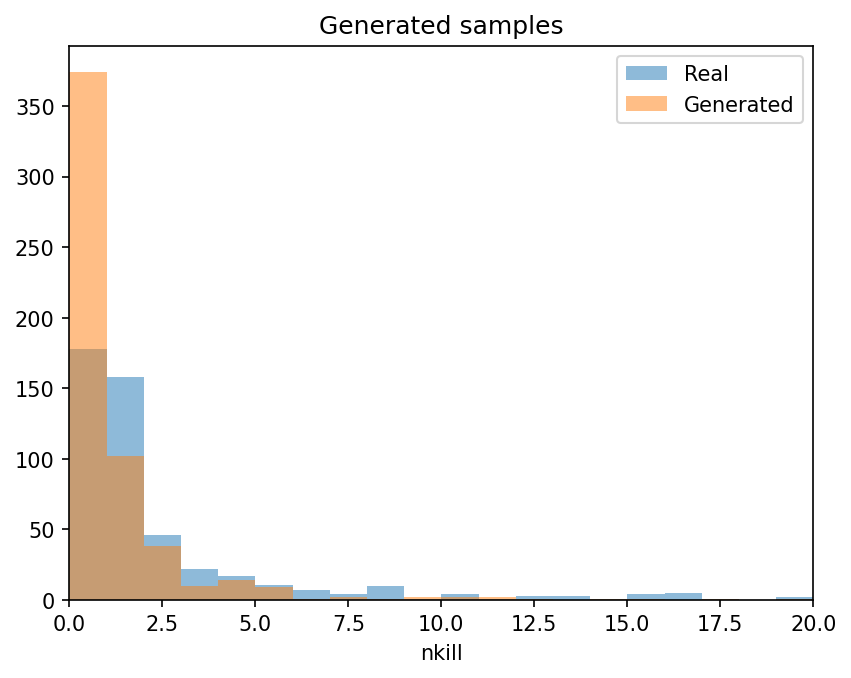

In [38]:
def hist_compare(y_real, y_gen):
    plt.figure(dpi=150)
    max_val = int(max(y_real.max(), y_gen.max())) + 1
    bins = range(0, max_val + 1)
    y_real.hist(alpha=0.5, label="Real", bins=bins)
    y_gen.hist(alpha=0.5, label="Generated", bins=bins)
    plt.legend()
    plt.title("Generated samples")
    plt.xlabel(y_real.name)
    plt.xlim(0,20)
    plt.grid()
    plt.show()


hist_compare(df['nkill'], df_2_ppc.iloc[0][8:])

In [39]:
for n in range(0, 100):
    true_count = np.sum(df['nkill'] == n)
    pred_count = np.sum(np.round(df_2_ppc.iloc[0][8:]) == n)
    if true_count != 0 or pred_count != 0:
        print(f"Number of victims = {n}: Real = {true_count}, Predicted = {pred_count}")

Number of victims = 0: Real = 178, Predicted = 389
Number of victims = 1: Real = 158, Predicted = 121
Number of victims = 2: Real = 46, Predicted = 38
Number of victims = 3: Real = 22, Predicted = 10
Number of victims = 4: Real = 17, Predicted = 14
Number of victims = 5: Real = 11, Predicted = 9
Number of victims = 6: Real = 7, Predicted = 1
Number of victims = 7: Real = 4, Predicted = 2
Number of victims = 8: Real = 10, Predicted = 1
Number of victims = 9: Real = 1, Predicted = 2
Number of victims = 10: Real = 4, Predicted = 2
Number of victims = 11: Real = 1, Predicted = 2
Number of victims = 12: Real = 3, Predicted = 1
Number of victims = 13: Real = 3, Predicted = 0
Number of victims = 14: Real = 1, Predicted = 1
Number of victims = 15: Real = 4, Predicted = 1
Number of victims = 16: Real = 5, Predicted = 0
Number of victims = 17: Real = 1, Predicted = 1
Number of victims = 19: Real = 2, Predicted = 1
Number of victims = 20: Real = 2, Predicted = 0
Number of victims = 22: Real = 1, 

Rozmiar x (val_mat[col]): 500
Rozmiar y (y_values_gen): 500
Rozmiar x (val_mat[col]): 500
Rozmiar y (y_values_gen): 500
Rozmiar x (val_mat[col]): 500
Rozmiar y (y_values_gen): 500
Rozmiar x (val_mat[col]): 500
Rozmiar y (y_values_gen): 500
Rozmiar x (val_mat[col]): 500
Rozmiar y (y_values_gen): 500


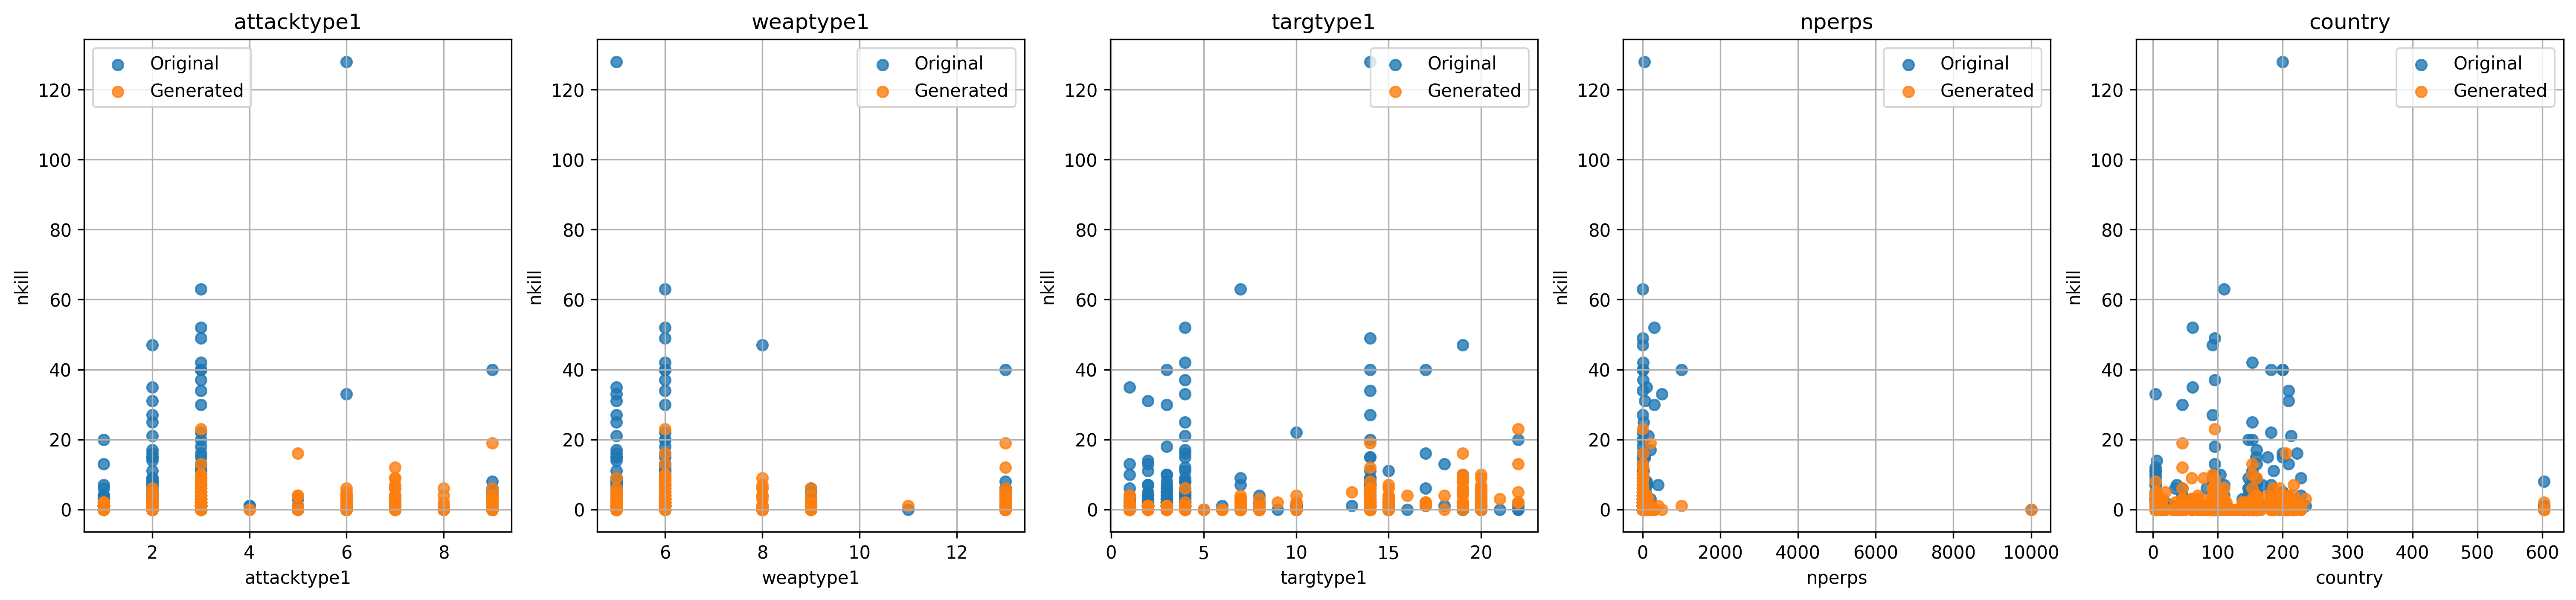

In [ ]:
scatter_compare_display(X, df["nkill"], df_2_ppc.iloc[0][17:])

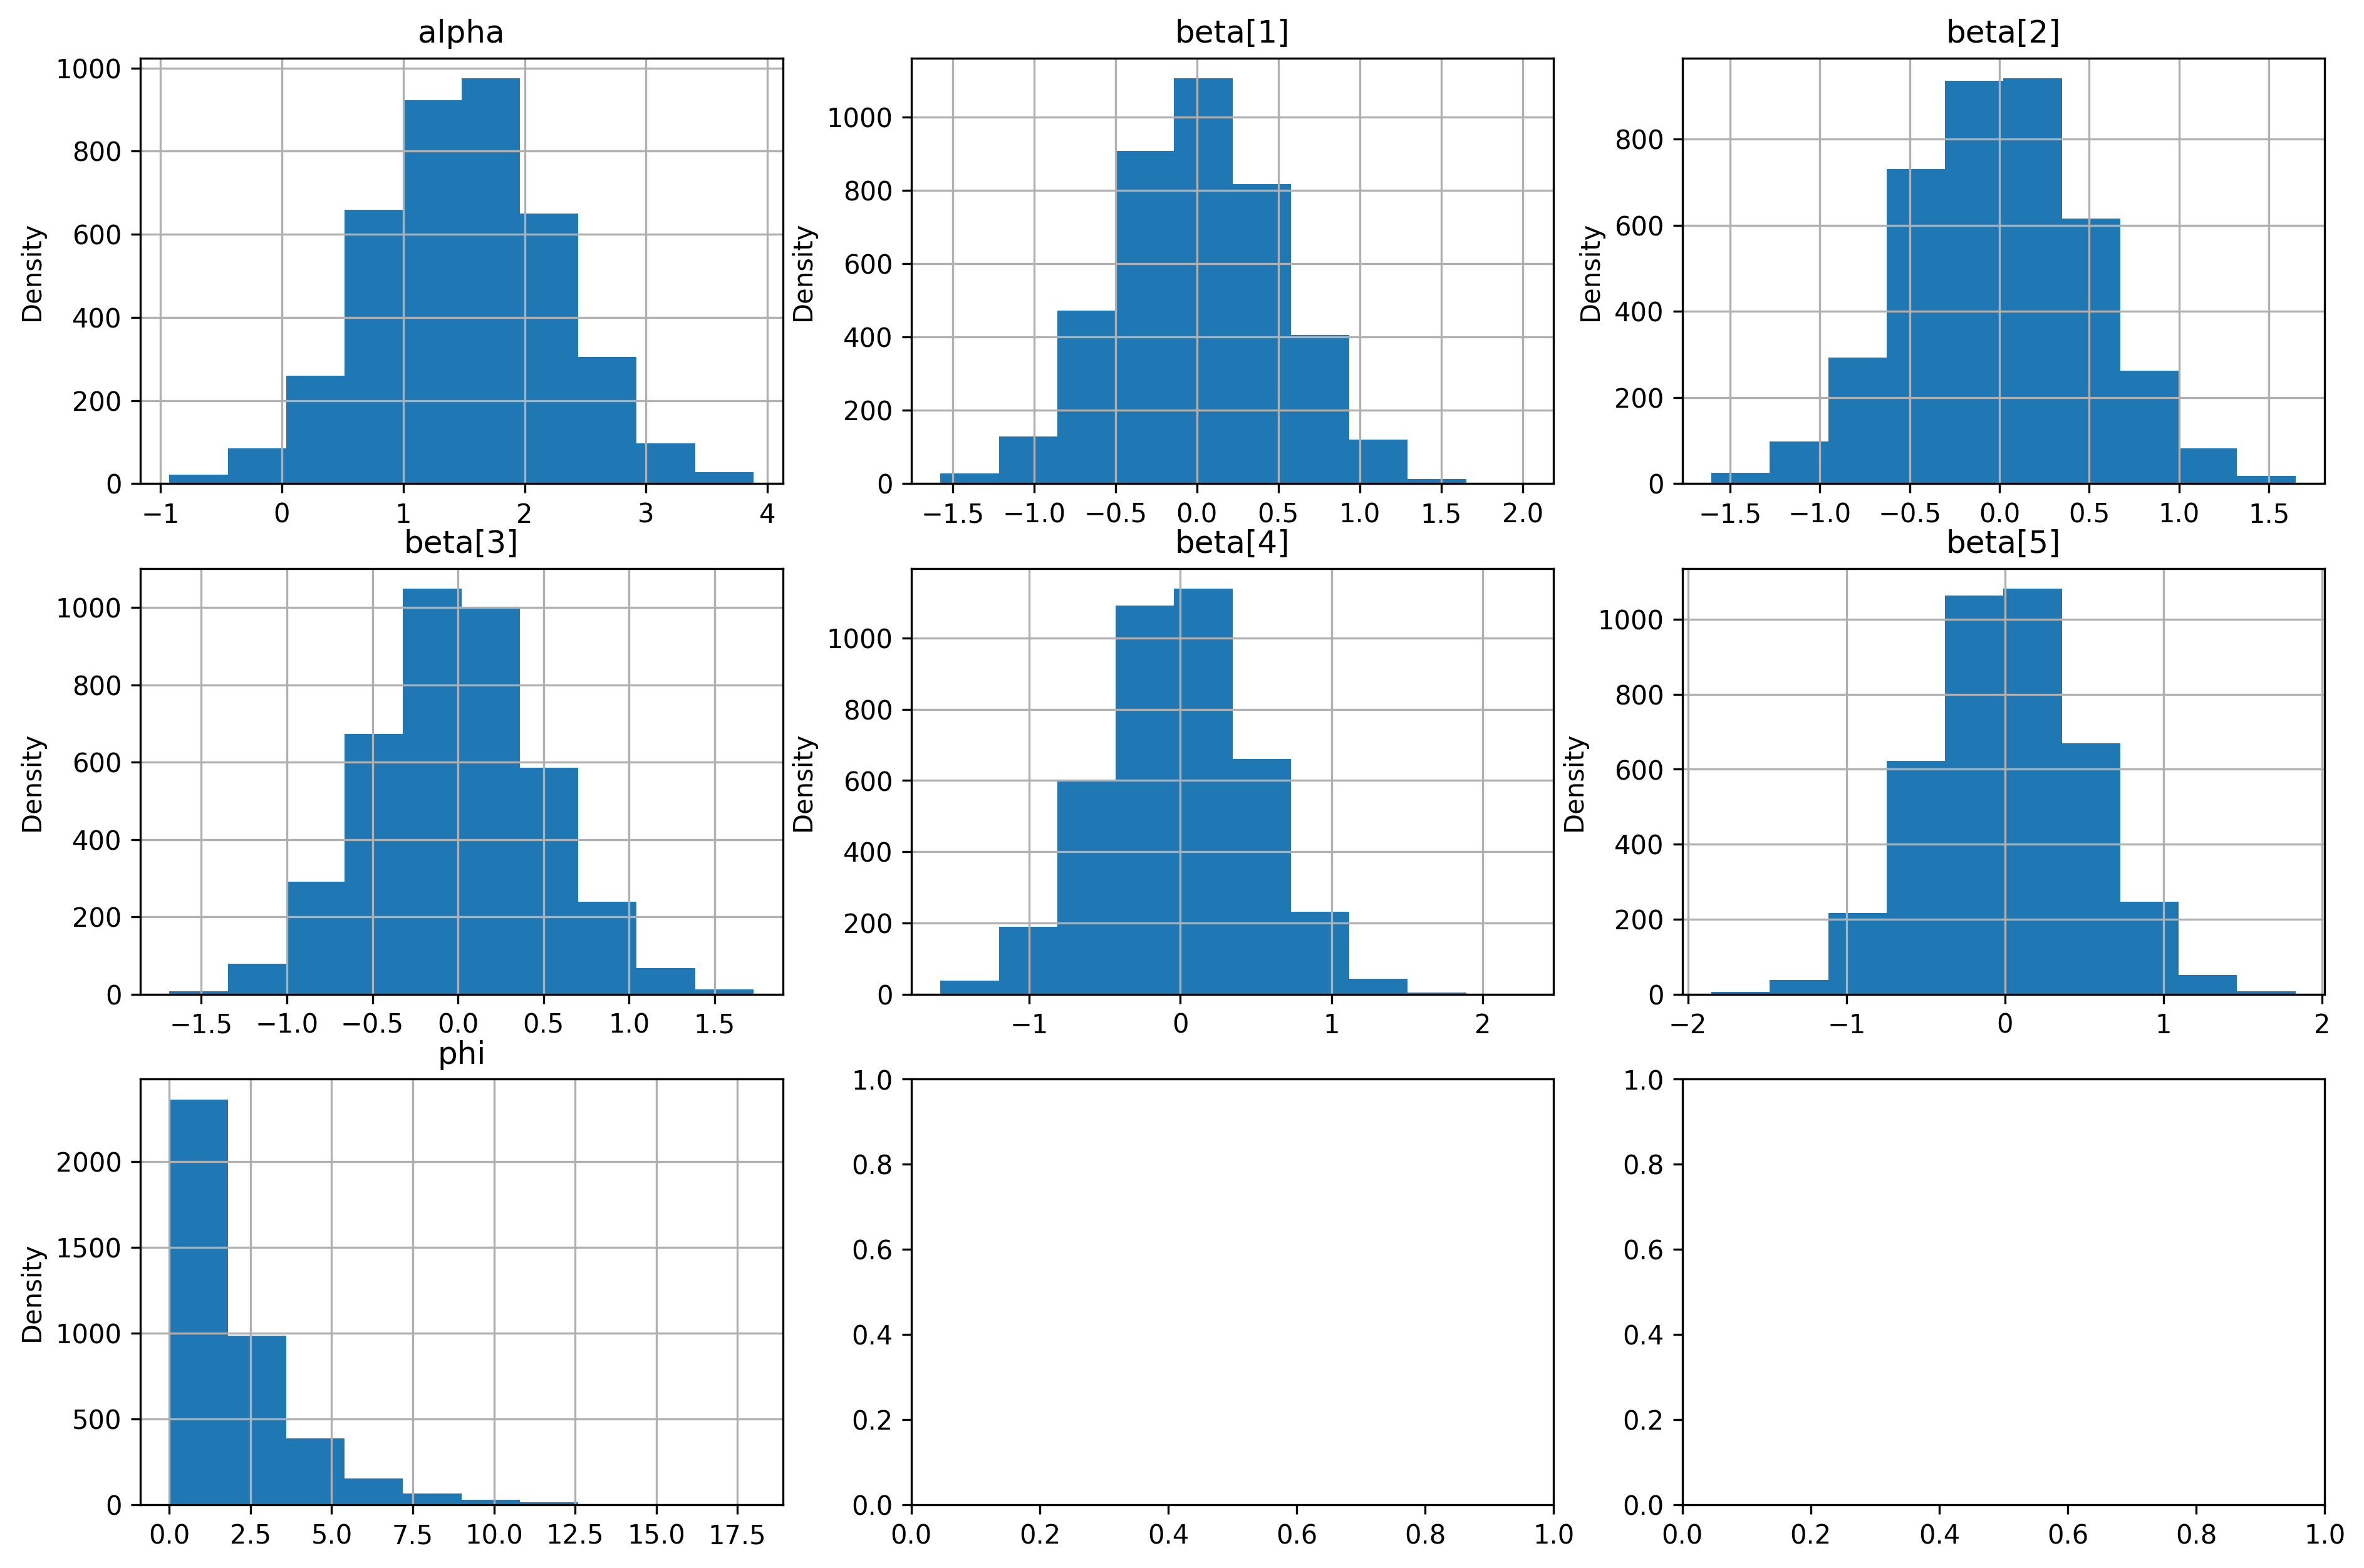

In [40]:
fig, axs = plt.subplots(3, 3, dpi=300)
fig.set_size_inches(15, 10)

for i, col in enumerate(["alpha", 'beta[1]', 'beta[2]', 'beta[3]', 'beta[4]', 'beta[5]', 'phi']):
    axs[i//3, i%3].hist(df_2_ppc[col])
    axs[i//3, i%3].set_ylabel("Density")
    axs[i//3, i%3].set_title(col)
    axs[i//3, i%3].grid()

### 5. Posterior analysis

#### Model 1

In [41]:
model1_prod = CmdStanModel(stan_file=MODEL_PATH_1)

sim1_prod = model1_prod.sample(data=data_sim_prod,
                                seed=123)

df_1_prod = sim1_prod.draws_pd()

13:20:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:20:07 - cmdstanpy - INFO - CmdStan done processing.


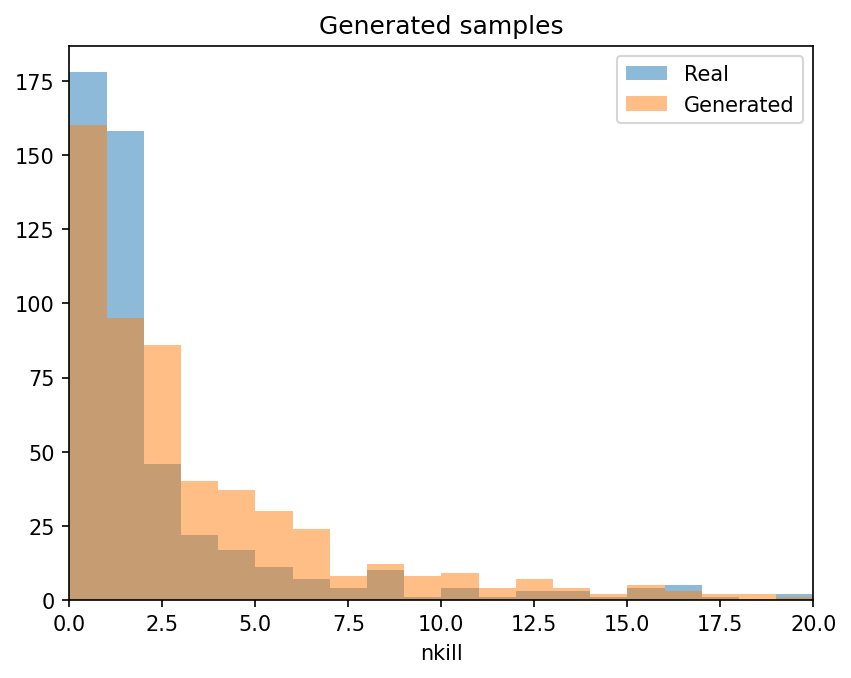

In [42]:
hist_compare(df['nkill'], df_1_prod.iloc[0][8:])

In [43]:
for n in range(0, 100):
    true_count = np.sum(df['nkill'] == n)
    pred_count = np.sum(np.round(df_1_prod.iloc[0][8:]) == n)
    if true_count != 0 or pred_count != 0:
        print(f"Number of victims = {n}: Real = {true_count}, Predicted = {pred_count}")

Number of victims = 0: Real = 178, Predicted = 198
Number of victims = 1: Real = 158, Predicted = 104
Number of victims = 2: Real = 46, Predicted = 87
Number of victims = 3: Real = 22, Predicted = 40
Number of victims = 4: Real = 17, Predicted = 37
Number of victims = 5: Real = 11, Predicted = 30
Number of victims = 6: Real = 7, Predicted = 24
Number of victims = 7: Real = 4, Predicted = 8
Number of victims = 8: Real = 10, Predicted = 12
Number of victims = 9: Real = 1, Predicted = 8
Number of victims = 10: Real = 4, Predicted = 9
Number of victims = 11: Real = 1, Predicted = 4
Number of victims = 12: Real = 3, Predicted = 7
Number of victims = 13: Real = 3, Predicted = 4
Number of victims = 14: Real = 1, Predicted = 2
Number of victims = 15: Real = 4, Predicted = 5
Number of victims = 16: Real = 5, Predicted = 3
Number of victims = 17: Real = 1, Predicted = 2
Number of victims = 18: Real = 0, Predicted = 2
Number of victims = 19: Real = 2, Predicted = 1
Number of victims = 20: Real = 

Rozmiar x (val_mat[col]): 500
Rozmiar y (y_values_gen): 500
Rozmiar x (val_mat[col]): 500
Rozmiar y (y_values_gen): 500
Rozmiar x (val_mat[col]): 500
Rozmiar y (y_values_gen): 500
Rozmiar x (val_mat[col]): 500
Rozmiar y (y_values_gen): 500
Rozmiar x (val_mat[col]): 500
Rozmiar y (y_values_gen): 500


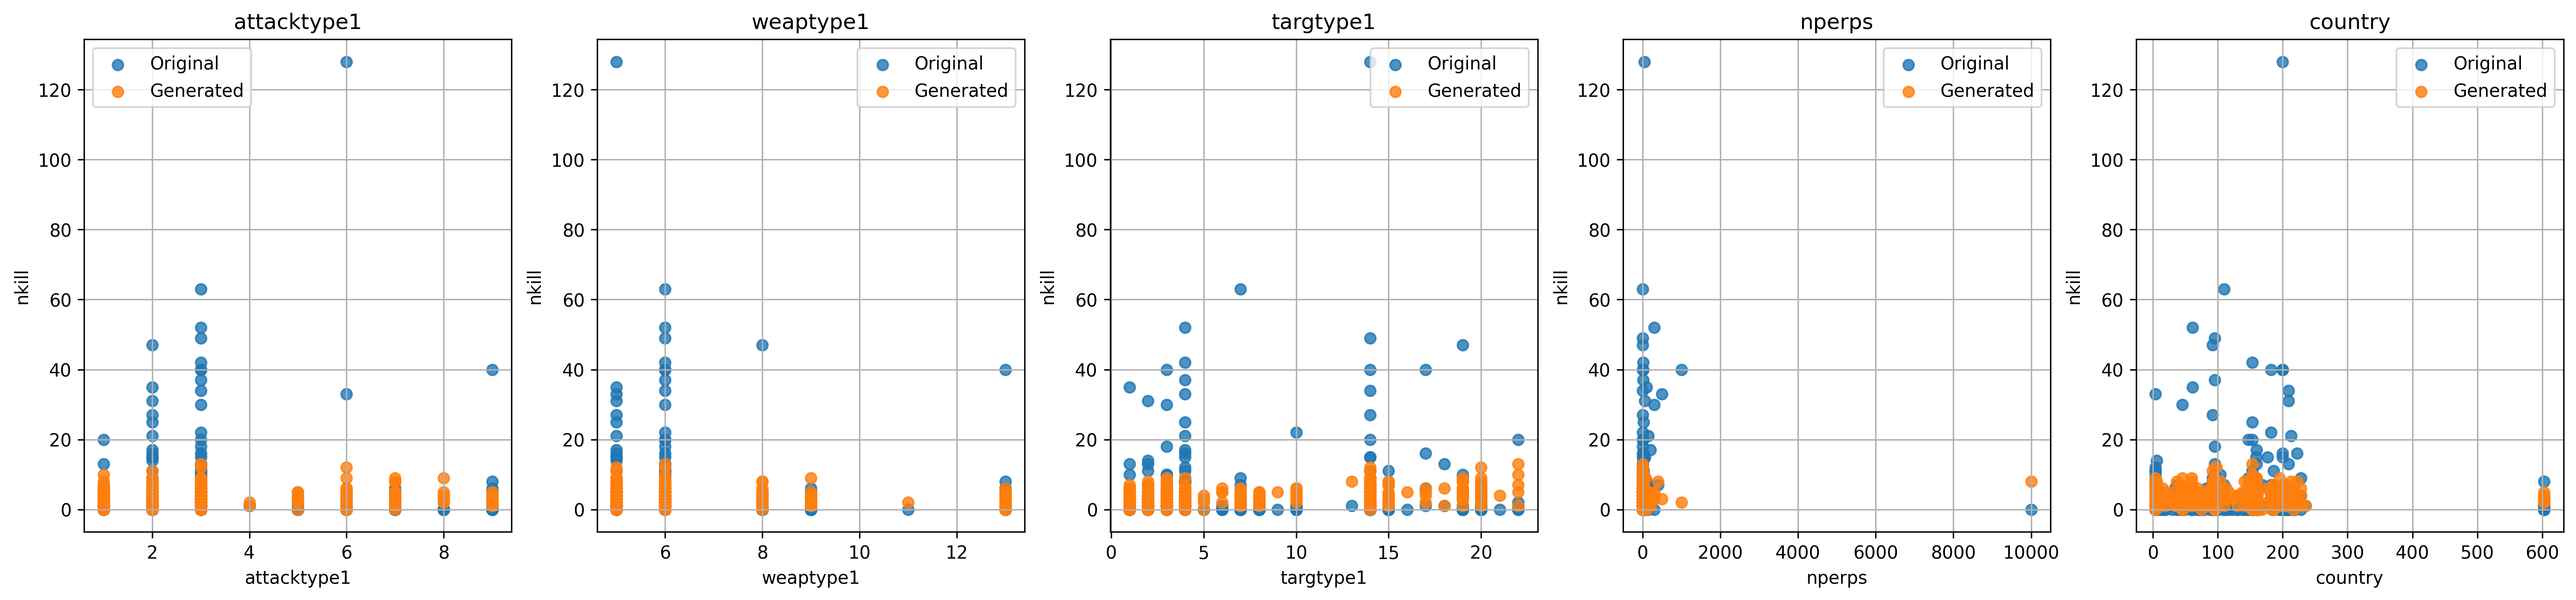

In [ ]:
scatter_compare_display(X, df["nkill"], df_1_prod.iloc[0][16:])

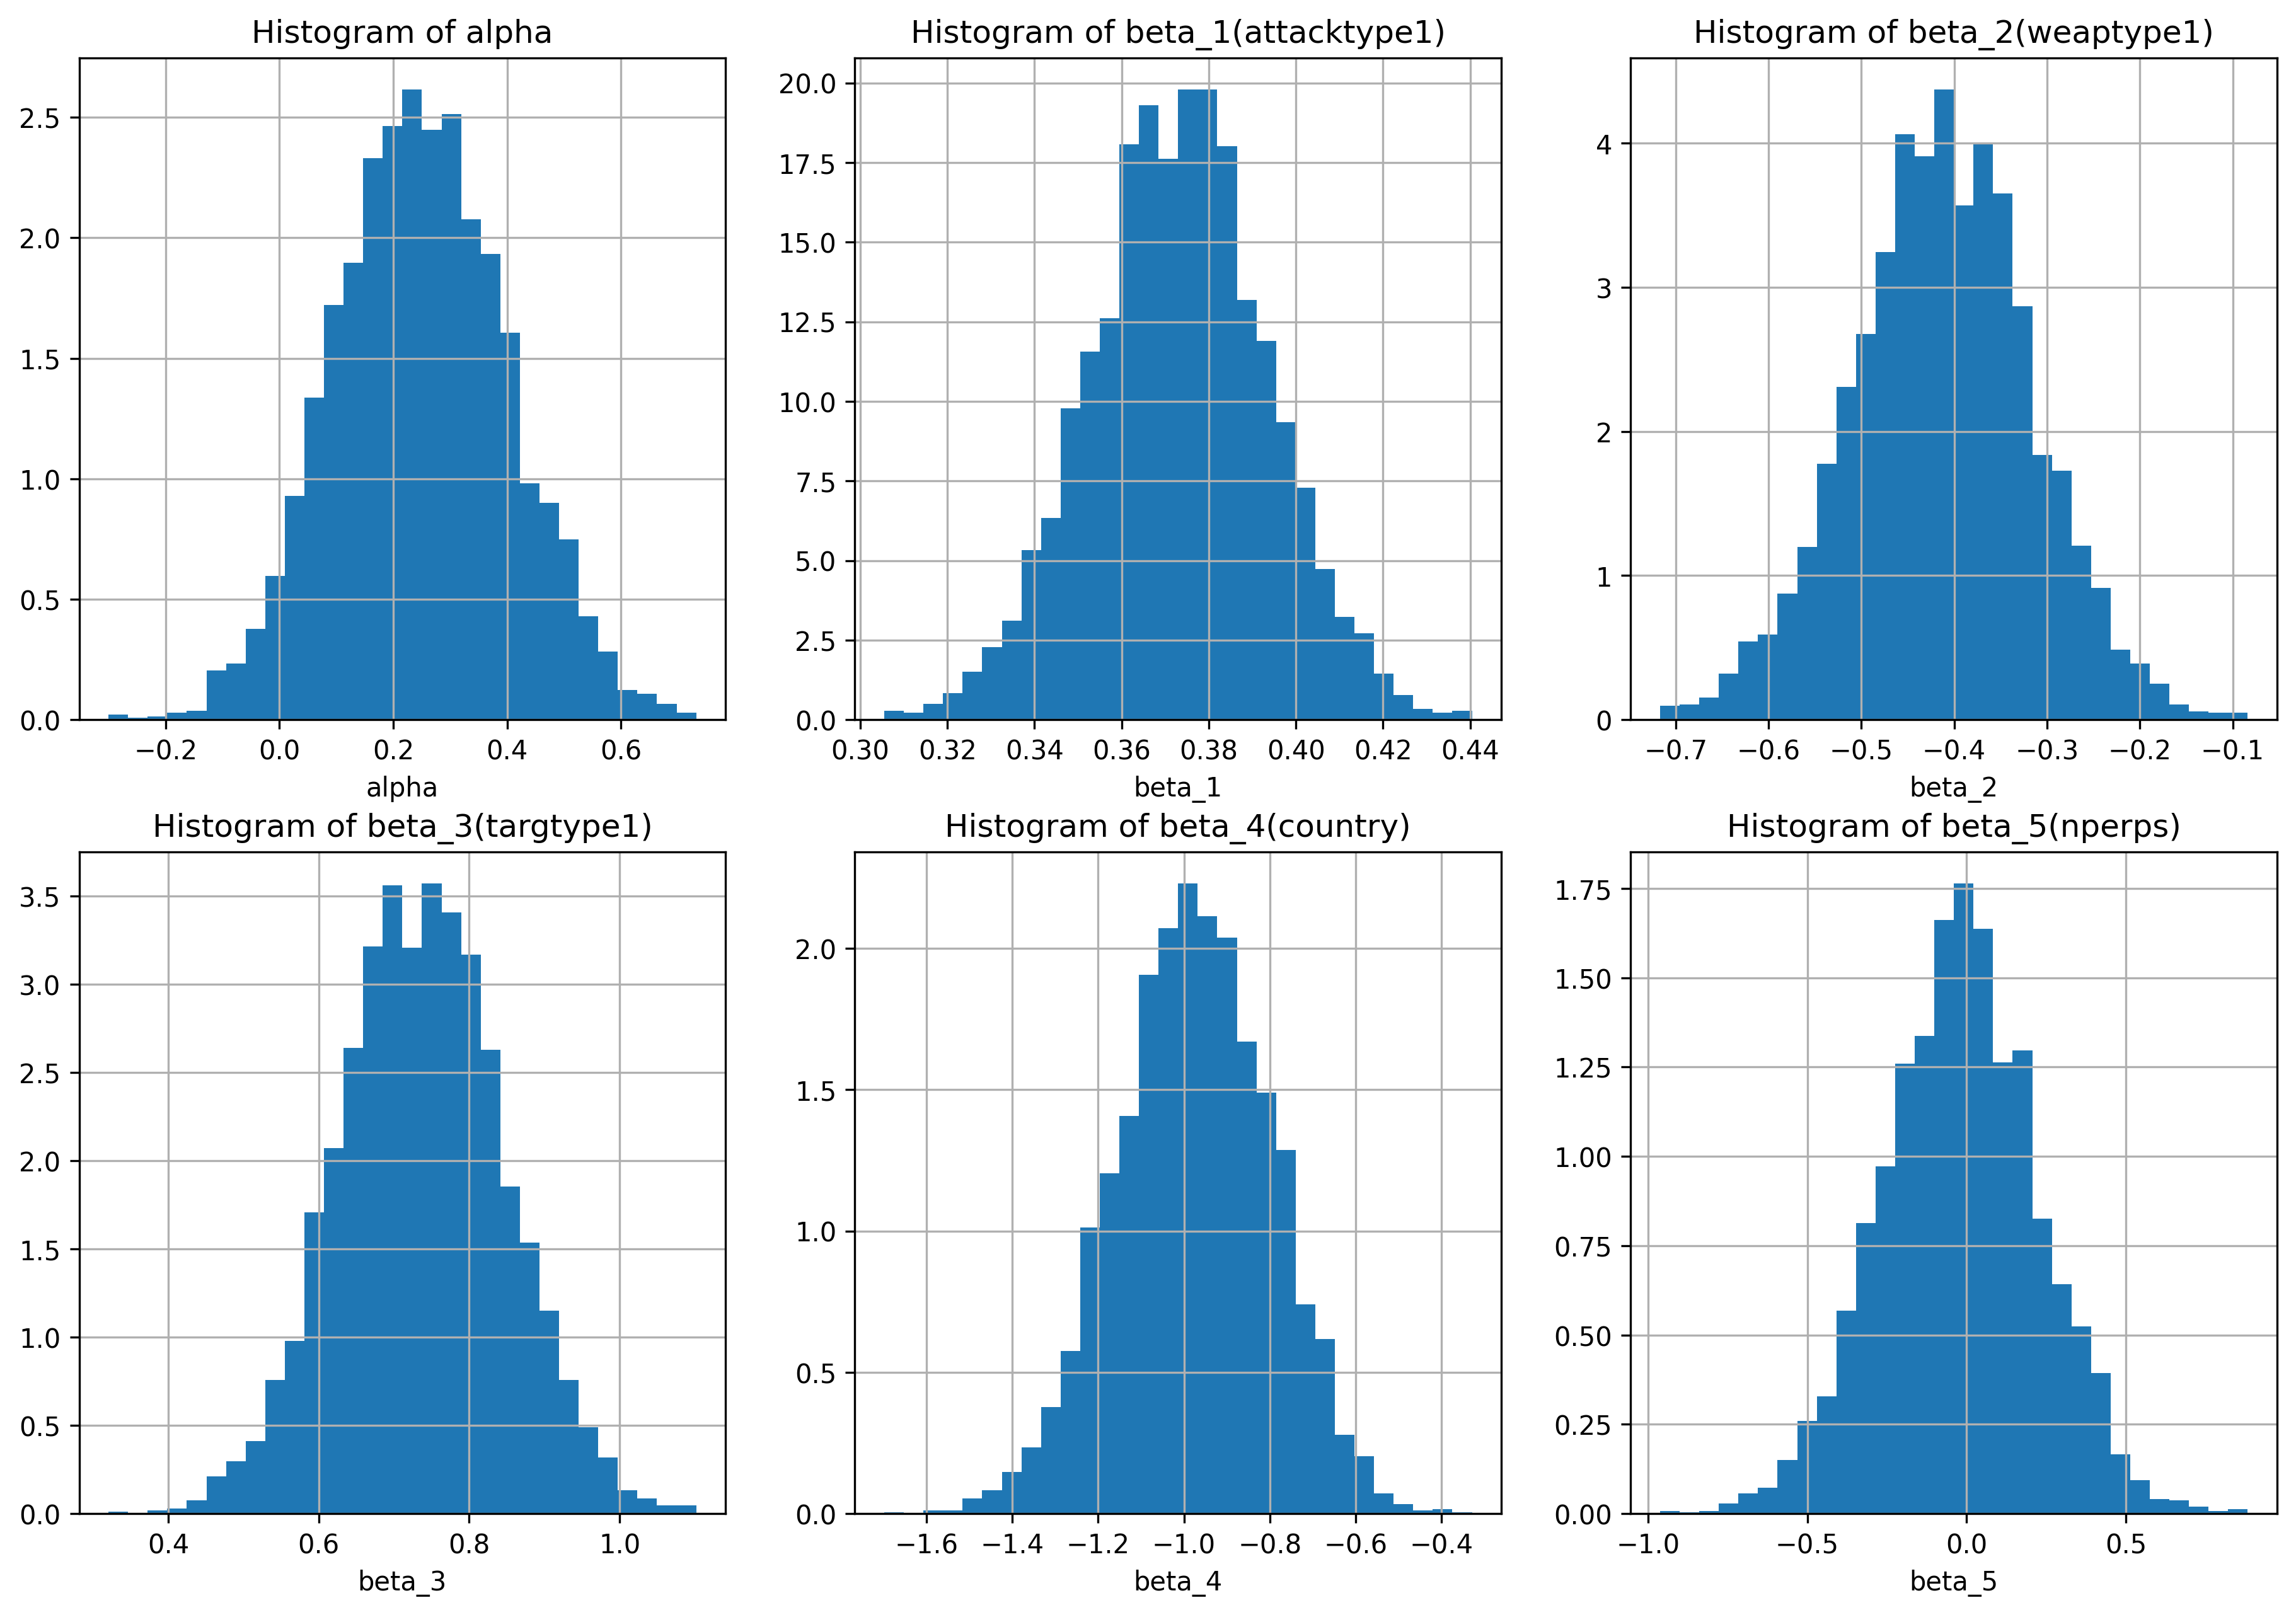

In [44]:
alpha = sim1_prod.stan_variable('alpha')
beta = sim1_prod.stan_variable('beta')

# plt.figure(dpi=300)
fig, axes = plt.subplots(2, 3, figsize=(15, 10), dpi=300)

axes[0, 0].hist(alpha, bins=30, density=True)
axes[0, 0].set_title(f'Histogram of alpha')
axes[0, 0].set_xlabel(f'alpha')
axes[0, 0].grid()

for i, el in enumerate(['attacktype1', 'weaptype1', 'targtype1', 'country', 'nperps']):
    axes[(i+1)//3, (i+1)%3].hist(beta[:, i], bins=30, density=True)
    axes[(i+1)//3, (i+1)%3].set_title(f'Histogram of beta_{i+1}({el})')
    axes[(i+1)//3, (i+1)%3].set_xlabel(f'beta_{i+1}')
    axes[(i+1)//3, (i+1)%3].grid()


plt.show()

#### Model 2


In [45]:
model1_prod = CmdStanModel(stan_file=MODEL_PATH_2)

sim2_prod = model1_prod.sample(data=data_sim_prod,
                                seed=123)

df_2_prod = sim2_prod.draws_pd()

13:20:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:20:33 - cmdstanpy - INFO - CmdStan done processing.
13:20:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be positive finite! (in 'code_2.stan', line 19, column 2 to column 52)
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be positive finite! (in 'code_2.stan', line 19, column 2 to column 52)
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be positive finite! (in 'code_2.stan', line 19, column 2 to column 52)
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be positive finite! (in 'code_2.stan', line 19, column 2 to column 52)
Consider re-running with show_console=True if the above output is unclear!


In [ ]:
df_2_prod

,chain__,iter__,draw__,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,...,nkill_pred[491],nkill_pred[492],nkill_pred[493],nkill_pred[494],nkill_pred[495],nkill_pred[496],nkill_pred[497],nkill_pred[498],nkill_pred[499],nkill_pred[500]
0,1.0,1.0,1.0,-1073.83,0.817651,0.579008,3.0,7.0,0.0,1076.63,...,0.0,5.0,0.0,7.0,19.0,0.0,0.0,2.0,3.0,0.0
1,1.0,2.0,2.0,-1075.01,0.943041,0.579008,3.0,7.0,0.0,1076.63,...,3.0,0.0,5.0,7.0,1.0,2.0,1.0,1.0,1.0,0.0
2,1.0,3.0,3.0,-1075.11,0.879324,0.579008,3.0,7.0,0.0,1078.62,...,0.0,1.0,0.0,2.0,0.0,16.0,0.0,0.0,0.0,0.0
3,1.0,4.0,4.0,-1075.89,0.949750,0.579008,3.0,7.0,0.0,1078.71,...,1.0,0.0,1.0,1.0,1.0,2.0,1.0,0.0,2.0,0.0
4,1.0,5.0,5.0,-1075.62,0.993658,0.579008,3.0,7.0,0.0,1080.81,...,0.0,0.0,2.0,0.0,5.0,7.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,4.0,996.0,3996.0,-1072.56,0.826901,0.596931,3.0,7.0,0.0,1078.25,...,0.0,12.0,0.0,0.0,6.0,2.0,4.0,0.0,0.0,0.0
3996,4.0,997.0,3997.0,-1076.61,0.790307,0.596931,3.0,7.0,0.0,1078.57,...,7.0,0.0,3.0,0.0,0.0,5.0,20.0,3.0,0.0,19.0
3997,4.0,998.0,3998.0,-1073.92,0.779017,0.596931,3.0,7.0,0.0,1081.73,...,8.0,24.0,0.0,0.0,0.0,11.0,5.0,0.0,1.0,0.0
3998,4.0,999.0,3999.0,-1077.35,0.786501,0.596931,2.0,3.0,0.0,1078.56,...,8.0,50.0,6.0,16.0,0.0,10.0,0.0,4.0,0.0,1.0


In [ ]:
# hist_compare(df['nkill'], df_2_prod.iloc[0][8:])

In [ ]:
for n in range(0, 2000):
    true_count = np.sum(df['nkill'] == n)
    pred_count = np.sum(np.round(df_2_prod.iloc[0][8:]) == n)
    if true_count != 0 or pred_count != 0:
        print(f"Number of victims = {n}: Real = {true_count}, Predicted = {pred_count}")

Number of victims = 0: Real = 7373, Predicted = 6
Number of victims = 1: Real = 5519, Predicted = 2
Number of victims = 2: Real = 1822, Predicted = 0
Number of victims = 3: Real = 1129, Predicted = 0
Number of victims = 4: Real = 704, Predicted = 0
Number of victims = 5: Real = 527, Predicted = 0
Number of victims = 6: Real = 426, Predicted = 0
Number of victims = 7: Real = 316, Predicted = 0
Number of victims = 8: Real = 279, Predicted = 0
Number of victims = 9: Real = 174, Predicted = 0
Number of victims = 10: Real = 192, Predicted = 0
Number of victims = 11: Real = 126, Predicted = 0
Number of victims = 12: Real = 130, Predicted = 0
Number of victims = 13: Real = 102, Predicted = 0
Number of victims = 14: Real = 105, Predicted = 0
Number of victims = 15: Real = 90, Predicted = 0
Number of victims = 16: Real = 85, Predicted = 0
Number of victims = 17: Real = 54, Predicted = 0
Number of victims = 18: Real = 54, Predicted = 0
Number of victims = 19: Real = 47, Predicted = 0
Number of v

Rozmiar x (val_mat[col]): 20000
Rozmiar y (y_values_gen): 20000
Rozmiar x (val_mat[col]): 20000
Rozmiar y (y_values_gen): 20000
Rozmiar x (val_mat[col]): 20000
Rozmiar y (y_values_gen): 20000
Rozmiar x (val_mat[col]): 20000
Rozmiar y (y_values_gen): 20000
Rozmiar x (val_mat[col]): 20000
Rozmiar y (y_values_gen): 20000


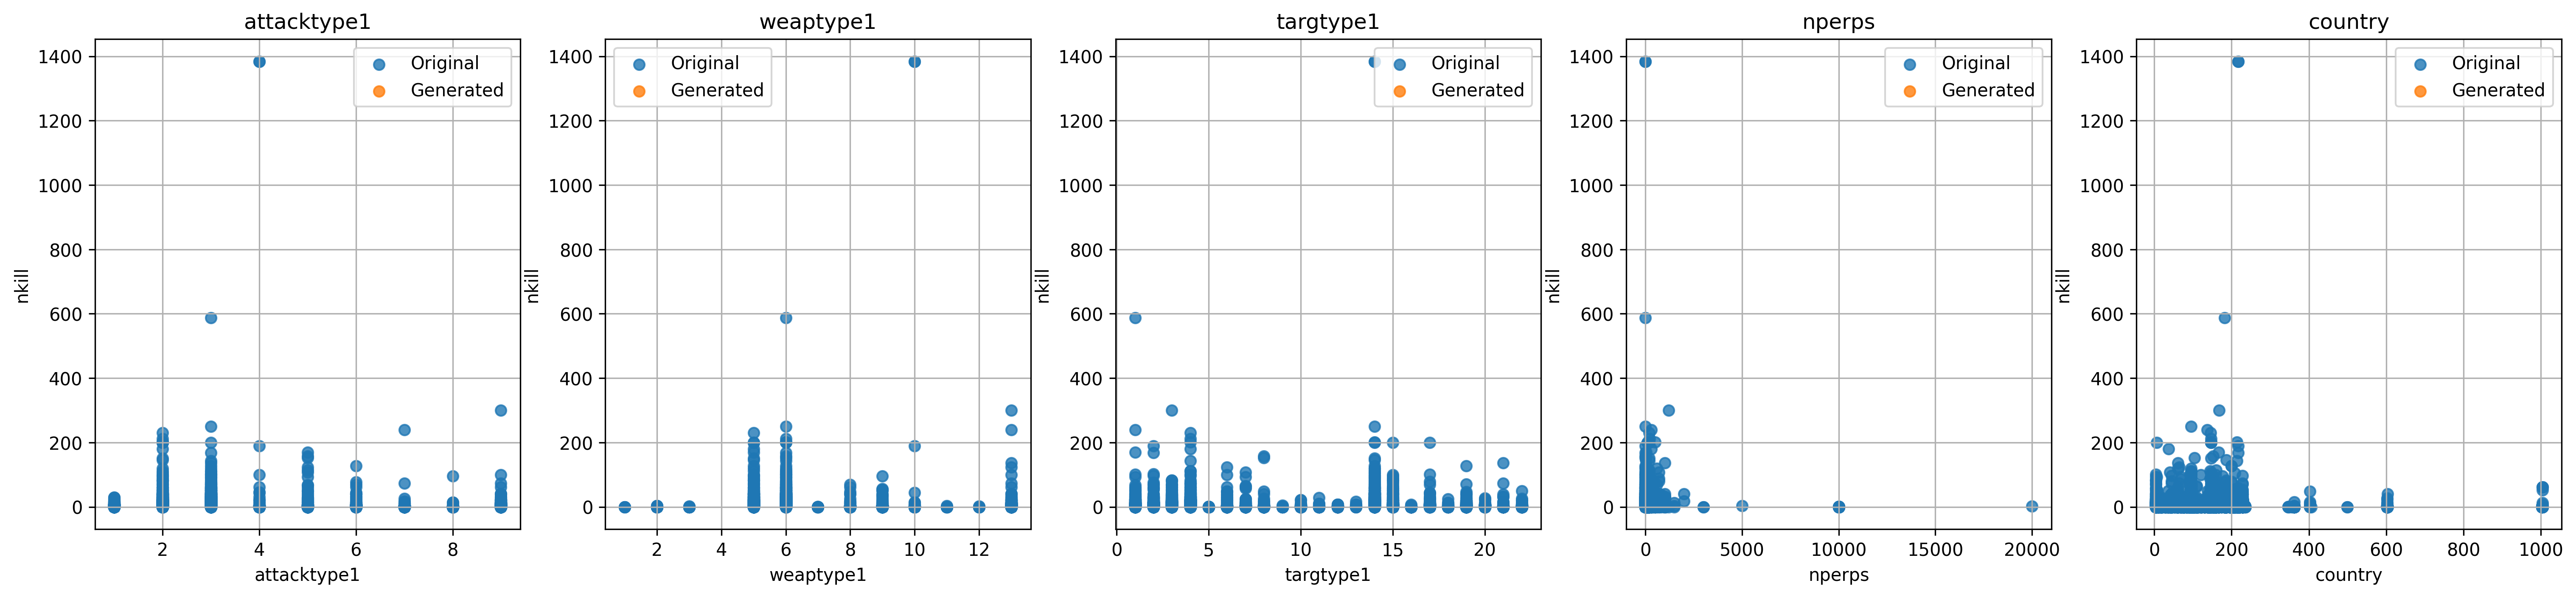

In [ ]:
scatter_compare_display(X, df["nkill"], df_2_prod.iloc[0][17:])

alpha shape: (4000,)
beta shape: (4000, 5)
[[-0.0969311   0.0476462   0.154518    0.677666   -0.0455978 ]
 [-0.0659874   0.00207751  0.154999    0.792361   -0.0554292 ]
 [-0.106357    0.0382939   0.142217    0.806003   -0.0594242 ]
 ...
 [-0.107606    0.0420413   0.158106    0.595129   -0.0344363 ]
 [-0.103655    0.0459436   0.169114    0.657554   -0.0272784 ]
 [-0.119786    0.0526093   0.139197    0.687916   -0.0424869 ]]


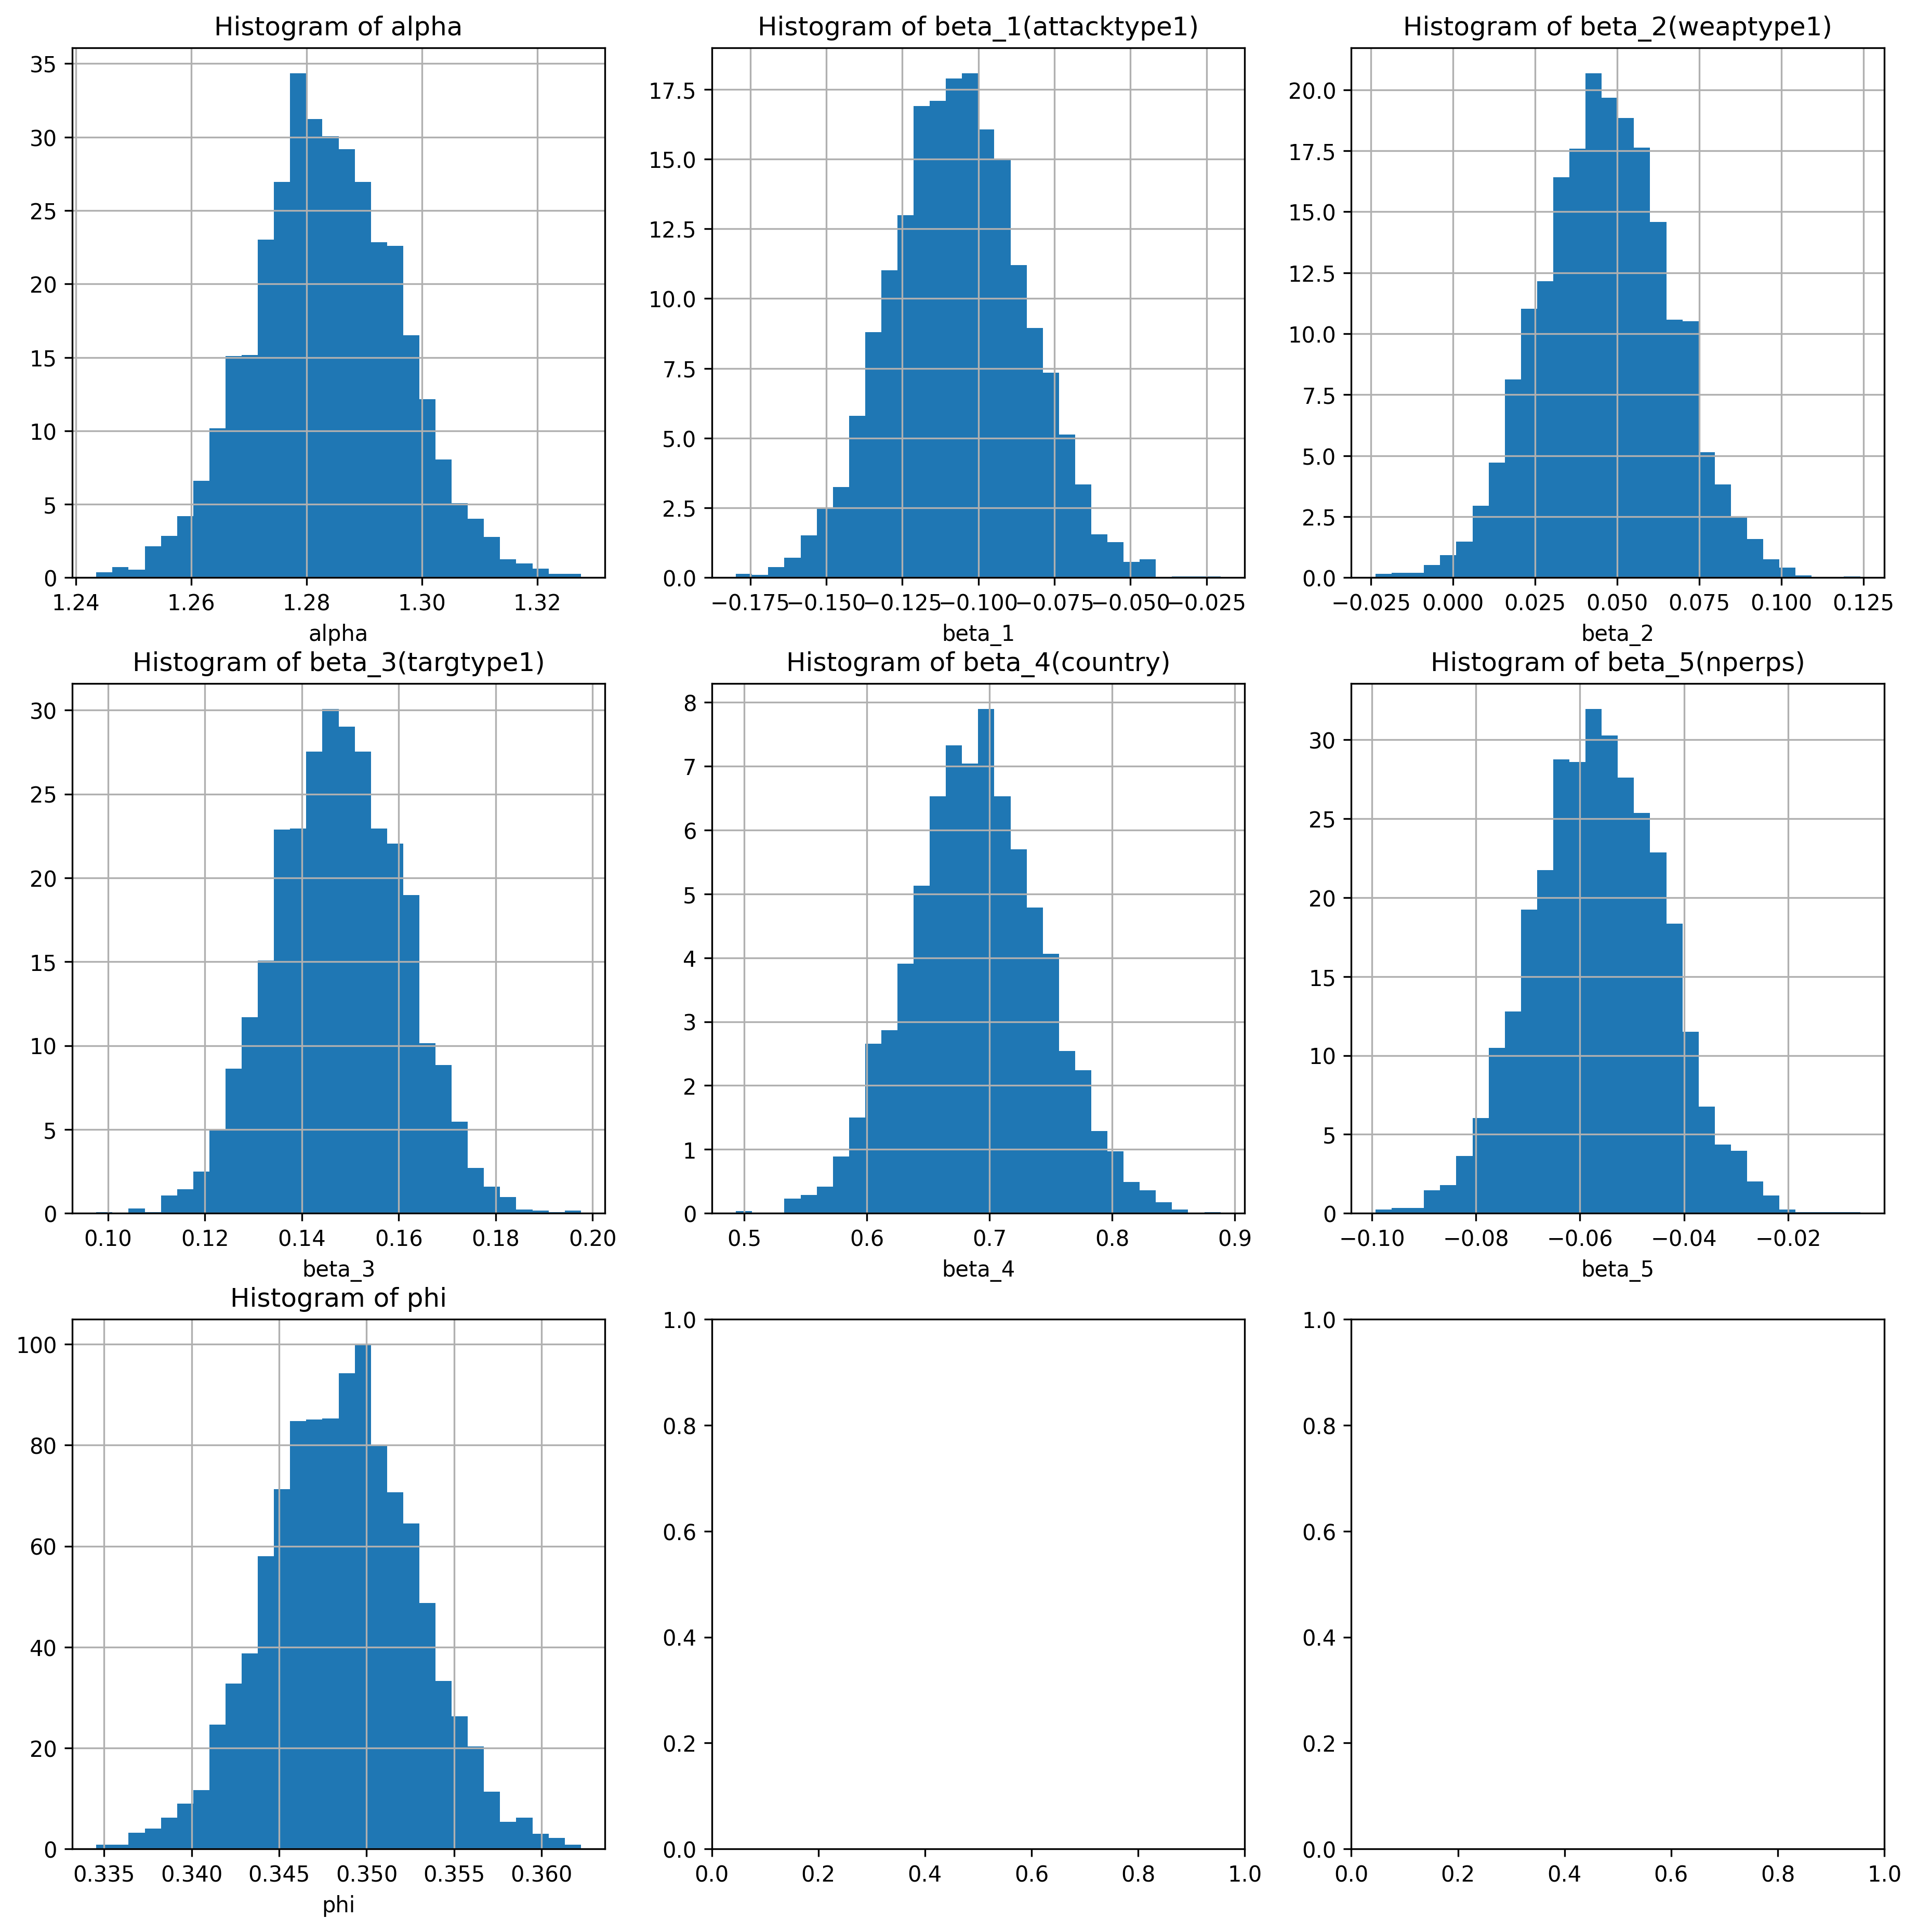

In [ ]:
alpha = sim2_prod.stan_variable('alpha')
beta = sim2_prod.stan_variable('beta')
phi = sim2_prod.stan_variable('phi')
print("alpha shape:", alpha.shape)
print("beta shape:", beta.shape)
print(beta)

# plt.figure(dpi=300)
fig, axes = plt.subplots(3, 3, figsize=(15, 15), dpi=300)

axes[0, 0].hist(alpha, bins=30, density=True)
axes[0, 0].set_title(f'Histogram of alpha')
axes[0, 0].set_xlabel(f'alpha')
axes[0, 0].grid()

for i, el in enumerate(['attacktype1', 'weaptype1', 'targtype1', 'country', 'nperps']):
    axes[(i+1)//3, (i+1)%3].hist(beta[:, i], bins=30, density=True)
    axes[(i+1)//3, (i+1)%3].set_title(f'Histogram of beta_{i+1}({el})')
    axes[(i+1)//3, (i+1)%3].set_xlabel(f'beta_{i+1}')
    axes[(i+1)//3, (i+1)%3].grid()

axes[2, 0].hist(phi, bins=30, density=True)
axes[2, 0].set_title(f'Histogram of phi')
axes[2, 0].set_xlabel(f'phi')
axes[2, 0].grid()


plt.show()

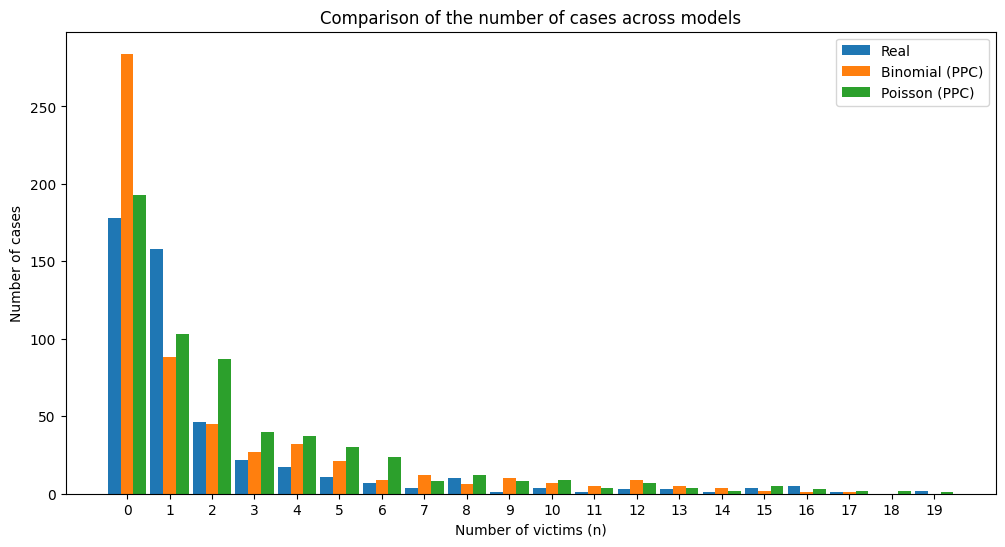

In [46]:
n_values = np.arange(0, 20)


true_counts = []
binomial_counts = []
poisson_counts = []

for n in n_values:
    true_count = np.sum(df["nkill"].values == n)
    binomial_count = np.sum(np.round(df_2_prod.iloc[0][16:]) == n)
    poisson_count = np.sum(np.round(df_1_prod.iloc[0][16:]) == n)
    
    true_counts.append(true_count)
    binomial_counts.append(binomial_count)
    poisson_counts.append(poisson_count)


bar_width = 0.3
index = np.arange(len(n_values))

plt.figure(figsize=(12,6))
plt.bar(index - bar_width, true_counts, bar_width, label='Real')
plt.bar(index, binomial_counts, bar_width, label='Binomial (PPC)')
plt.bar(index + bar_width, poisson_counts, bar_width, label='Poisson (PPC)')

plt.xlabel('Number of victims (n)')
plt.ylabel('Number of cases')
plt.xticks(index, n_values)
plt.legend()
plt.title('Comparison of the number of cases across models')
plt.show()

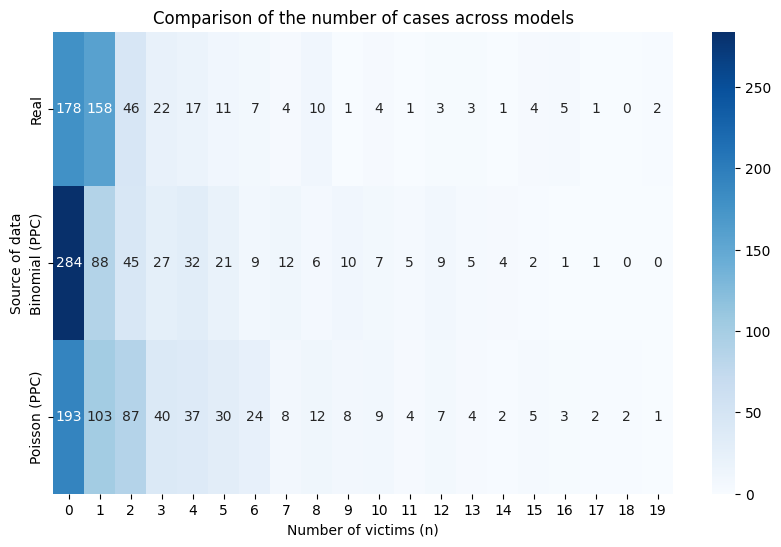

In [47]:
df_heatmap = pd.DataFrame({
    'n': n_values,
    'Real': true_counts,
    'Binomial (PPC)': binomial_counts,
    'Poisson (PPC)': poisson_counts
}).set_index('n')

plt.figure(figsize=(10,6))
sns.heatmap(df_heatmap.T, annot=True, fmt='d', cmap='Blues')
plt.title('Comparison of the number of cases across models')
plt.xlabel('Number of victims (n)')
plt.ylabel('Source of data')
plt.show()